# Análisis de sentimientos

### Importando librerías

In [1]:
import pandas as pd

import spacy

import nltk
from nltk.corpus import stopwords
from nltk import bigrams, trigrams, ngrams
from collections import defaultdict
from string import punctuation

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Janneth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Cargando datos

In [2]:
train = pd.read_csv('../data/processed/train.csv', index_col=[0], parse_dates=['Date'], dayfirst=True)
train.head()

,Title,Opinion,Place,Gender,Age,Country,Date,Label,Lang
1390,muy bueno,"la verdad no me gustaron para nada las momias,...",Museo de las Momias,Male,63,Estados Unidos,21/07/2013,1,es
2766,más que una gran escalera,este lugar es conocido por su incríble escalin...,Universidad de Guanajuato,Female,26,México,09/07/2014,1,es
3567,tour en guanajuato,¡sorprendente! algo muy interesante de ver.. d...,Museo de las Momias,Female,20,México,13/01/2017,1,es
763,punto turístico por excelencia,este es uno de los lugares que su visita es ob...,Monumento Pípila,Male,28,México,05/09/2016,0,es
3318,esperaba más,es un lugar romántico pero esperaba u poco más...,Callejón del Beso,Female,-1,México,2019,1,es


In [3]:
val = pd.read_csv('../data/processed/val.csv', index_col=[0], parse_dates=['Date'], dayfirst=True)
val.head()

,Title,Opinion,Place,Gender,Age,Country,Date,Label,Lang
577,decepcionante,desde que llegas y el museo parece más una ter...,Museo de las Momias,Male,42,México,06/01/2015,0,es
4031,casi la catedral,cerca del jardín unión encontraras este lugar ...,Basilica Colegiata,Female,38,México,21/11/2017,1,es
2390,un edificio emblemático,un edificio que vale a pena hacerle fotos desd...,Universidad de Guanajuato,Male,53,México,09/02/2016,1,es
4290,lugar típico,"me encantó, es muy divertido, te toman foto, t...",Callejón del Beso,Female,29,México,01/10/2017,1,es
4381,arquitectura espectacular,"no te cansas de admirar tremenda arquitectura,...",Universidad de Guanajuato,Female,49,México,02/06/2015,1,es


### Separar por etiqueta (Positivos y negativos)

In [4]:
train_opiniones_positivas = train[train['Label'] == 1]['Opinion']

train_opiniones_negativas = train[train['Label'] == 0]['Opinion']

train_opiniones_positivas.shape, train_opiniones_negativas.shape

((2891,), (616,))

### Aplicando técnicas para el balanceo de clases

#### 1. Sobremuestreo de la clase minoritaria (Oversampling)

In [506]:
# Duplicar las reseñas de la clase minoritaria (negativos)
opiniones_negativas_duplicadas = train_opiniones_negativas.sample(n=len(train_opiniones_positivas) - len(train_opiniones_negativas), replace=True, random_state=42)
print(opiniones_negativas_duplicadas.shape)

# Combinar el DataFrame original con las reseñas duplicadas
train_opiniones_negativas_balanceado = pd.concat([train_opiniones_negativas, opiniones_negativas_duplicadas])

train_opiniones_negativas_balanceado.shape

(2275,)


(2891,)

#### 2. Submuestreo de la clase mayoritaria (Undersampling)

In [242]:
# Realizar submuestreo de la clase mayoritaria para que tenga el mismo número de instancias que la clase minoritaria
train_opiniones_positivas_balanceado = train_opiniones_positivas.sample(n=len(train_opiniones_negativas), random_state=42)
train_opiniones_positivas_balanceado.shape


(616,)

#### 3. Combinación oversampling + undersampling

In [412]:
# Calcular número de reseñas que deberán tener ambos conjuntos
diff = len(train_opiniones_positivas) - len(train_opiniones_negativas)
n_muestras = int(diff / 2)

train_opiniones_positivas_balanceado = train_opiniones_positivas.sample(n=len(train_opiniones_positivas)-n_muestras, random_state=42)
print(train_opiniones_positivas_balanceado.shape)

# Duplicar las reseñas de la clase minoritaria (negativos)
opiniones_negativas_duplicadas = train_opiniones_negativas.sample(n=n_muestras, replace=True, random_state=42)


# Combinar el DataFrame original con las reseñas duplicadas
train_opiniones_negativas_balanceado = pd.concat([train_opiniones_negativas, opiniones_negativas_duplicadas])

train_opiniones_negativas_balanceado.shape

(1754,)


(1753,)

### Tokenización

#### Signos de puntuación

In [413]:
# Lista de signos de puntuación
from string import punctuation
punctuations = list(punctuation)
print(punctuations)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']


#### Stopwords

In [414]:
stop_words = set(stopwords.words('spanish'))

#### Tokenización

In [507]:
# Tokenización con NLTK
words_train_positivas = [t for t in nltk.word_tokenize(" ".join(train_opiniones_positivas)) #train_opiniones_positivas #train_opiniones_positivas_balanceado
                         if t not in punctuations  # signos de puntuación
                            and t not in stop_words]   # stop words

words_train_negativas = [t for t in nltk.word_tokenize(" ".join(train_opiniones_negativas_balanceado)) #train_opiniones_negativas #train_opiniones_negativas_balanceado
                         if t not in punctuations  # signos de puntuación
                            and t not in stop_words]   # stop words

print(words_train_positivas[:20])
print(words_train_negativas[:20])

['verdad', 'gustaron', 'momias', 'interesante', 'ver', 'descomposición', 'daba', 'cadáveres', 'ciudad', 'paguen', 'extra', 'entrar', 'ver', 'artefactos', 'tortura', 'cosas', "'sobrenaturales", 'éso', 'mejor', 'paseo']
['lugares', 'visita', 'obligatoria', 'atardeceres', 'único', 'detalle', 'lugar', 'encuentra', 'descuidado', 'monumento', 'grafiteado', 'balaustradas', 'rotas', 'famosas', 'momias', 'guanajuato', 'museo', 'horrible', 'exhiben', 'sino']


#### N-gramas

In [508]:
# Número de n-gramas
n = 2

# Crear lista de n-gramas
n_gramas_positivos = list(ngrams(words_train_positivas, n))
n_gramas_negativos = list(ngrams(words_train_negativas, n))

print(n_gramas_positivos[:10])
print(n_gramas_negativos[:10])

[('verdad', 'gustaron'), ('gustaron', 'momias'), ('momias', 'interesante'), ('interesante', 'ver'), ('ver', 'descomposición'), ('descomposición', 'daba'), ('daba', 'cadáveres'), ('cadáveres', 'ciudad'), ('ciudad', 'paguen'), ('paguen', 'extra')]
[('lugares', 'visita'), ('visita', 'obligatoria'), ('obligatoria', 'atardeceres'), ('atardeceres', 'único'), ('único', 'detalle'), ('detalle', 'lugar'), ('lugar', 'encuentra'), ('encuentra', 'descuidado'), ('descuidado', 'monumento'), ('monumento', 'grafiteado')]


#### Modelo por conteo de frecuencias

In [509]:
# Modelo de conteos de n_gramas
frec_positivos = defaultdict(int) 
frec_negativos = defaultdict(int) 

 # Conteo por frecuencia de n-gramas
for n_grama in n_gramas_positivos:
    frec_positivos[n_grama] += 1 # Aumentar el conteo 

for n_grama in n_gramas_negativos:
    frec_negativos[n_grama] += 1 # Aumentar el conteo


In [510]:
frec_positivos

defaultdict(int,
            {('verdad', 'gustaron'): 1,
             ('gustaron', 'momias'): 1,
             ('momias', 'interesante'): 3,
             ('interesante', 'ver'): 8,
             ('ver', 'descomposición'): 1,
             ('descomposición', 'daba'): 1,
             ('daba', 'cadáveres'): 1,
             ('cadáveres', 'ciudad'): 1,
             ('ciudad', 'paguen'): 1,
             ('paguen', 'extra'): 1,
             ('extra', 'entrar'): 1,
             ('entrar', 'ver'): 4,
             ('ver', 'artefactos'): 1,
             ('artefactos', 'tortura'): 1,
             ('tortura', 'cosas'): 1,
             ('cosas', "'sobrenaturales"): 1,
             ("'sobrenaturales", 'éso'): 1,
             ('éso', 'mejor'): 1,
             ('mejor', 'paseo'): 1,
             ('paseo', 'museo'): 1,
             ('museo', 'momias'): 28,
             ('momias', 'lugar'): 6,
             ('lugar', 'conocido'): 2,
             ('conocido', 'incríble'): 1,
             ('incríble', 'escalin

In [511]:
frec_negativos

defaultdict(int,
            {('lugares', 'visita'): 12,
             ('visita', 'obligatoria'): 15,
             ('obligatoria', 'atardeceres'): 7,
             ('atardeceres', 'único'): 7,
             ('único', 'detalle'): 7,
             ('detalle', 'lugar'): 7,
             ('lugar', 'encuentra'): 24,
             ('encuentra', 'descuidado'): 17,
             ('descuidado', 'monumento'): 7,
             ('monumento', 'grafiteado'): 7,
             ('grafiteado', 'balaustradas'): 7,
             ('balaustradas', 'rotas'): 7,
             ('rotas', 'famosas'): 1,
             ('famosas', 'momias'): 13,
             ('momias', 'guanajuato'): 52,
             ('guanajuato', 'museo'): 20,
             ('museo', 'horrible'): 7,
             ('horrible', 'exhiben'): 7,
             ('exhiben', 'sino'): 7,
             ('sino', 'exhiben'): 7,
             ('exhiben', 'abuelo'): 7,
             ('abuelo', 'contó'): 7,
             ('contó', 'hace'): 7,
             ('hace', '40'): 15,
    

In [512]:
# Ejemplo de conteo de frecuencias de n-gramas con un texto
n_grama = ('tiempo', 'disfrutar')

#n_grama = ('lugares', 'visita', 'obligatoria')

#n_grama = ('el', 'edificio','está', 'muy')
#n_grama = ('es', 'muy', 'lindo', 'el')
#n_grama = ('no', 'me', 'gustó', 'nada')
#n_grama = ('se', 'encuentra', 'muy', 'descuidado')

#texto = ('lugares', 'visita', 'obligatoria', 'atardeceres')
print(f'Frecuencia en positivos:',frec_positivos[n_grama])
print(f'Frecuencia en negativos:',frec_negativos[n_grama])


Frecuencia en positivos: 2
Frecuencia en negativos: 0


### Validación

In [513]:
# Evaluación de un texto
# Regresa un score donde se suman las frecuencias de los n-gramas positivos y se restan las frecuencias de los n-gramas negativos
def evaluar_texto(texto, frec_positivos, frec_negativos, n):
    score = 0

    # Tokenización con NLTK
    words = [t for t in nltk.word_tokenize(texto) if t not in punctuations]
    #print(words)

    for n_grama in ngrams(words, n):
        score += frec_positivos[n_grama]
        score -= frec_negativos[n_grama]
        #print(n_grama, "+", frec_positivos[n_grama], "-", frec_negativos[n_grama])     
    return score


# Clasificación del score
def clasificar(score):
    if score >= 0:  #Positivo
        return 1
    else:
        return 0    #Negativo


In [514]:
# Ejemplo con un texto

#texto = 'el edificio está muy bonito'
#texto = 'es muy lindo el edificio'
#texto = 'se encuentra muy descuidado'
texto = 'hay una leyenda acerca de este lugar que me parece la de\nromeo y julieta de guanajuato, no la cuento completapara \nque quieran llegar, a mi me parecio muy romantica y este\nlugar debe ser un sitio obligatorio para todas las parejas que\nvisiten guanajuato, así atraeran sus siete años de buena\nsuerte'
evaluar_texto(texto, frec_positivos, frec_negativos, n)

13

In [515]:
# Mostrar todo el texto de las columnas
pd.set_option('display.max_colwidth', 100)

In [516]:
# Copia del conjunto de validación
df_val_opiniones = val.copy()
df_val_opiniones.head()

,Title,Opinion,Place,Gender,Age,Country,Date,Label,Lang
577,decepcionante,desde que llegas y el museo parece más una terminal vieja de autobuses de pueblo de mala muerte ...,Museo de las Momias,Male,42,México,06/01/2015,0,es
4031,casi la catedral,cerca del jardín unión encontraras este lugar emblemático y su arquitectura tipo barrocon con or...,Basilica Colegiata,Female,38,México,21/11/2017,1,es
2390,un edificio emblemático,un edificio que vale a pena hacerle fotos desde el pípila y una vez abajo verla de frente y subi...,Universidad de Guanajuato,Male,53,México,09/02/2016,1,es
4290,lugar típico,"me encantó, es muy divertido, te toman foto, te dicen cómo posar para el beso, el público se ríe...",Callejón del Beso,Female,29,México,01/10/2017,1,es
4381,arquitectura espectacular,"no te cansas de admirar tremenda arquitectura, pero si de subir las escaleras para preciar la vi...",Universidad de Guanajuato,Female,49,México,02/06/2015,1,es


#### Calcular el score y hacer la clasificación

In [517]:
df_val_opiniones['Score'] = df_val_opiniones['Opinion'].apply(lambda x: evaluar_texto(x, frec_positivos, frec_negativos, n))
df_val_opiniones['Clasificación'] = df_val_opiniones['Score'].apply(clasificar)

df_val_opiniones.head()

,Title,Opinion,Place,Gender,Age,Country,Date,Label,Lang,Score,Clasificación
577,decepcionante,desde que llegas y el museo parece más una terminal vieja de autobuses de pueblo de mala muerte ...,Museo de las Momias,Male,42,México,06/01/2015,0,es,-15,0
4031,casi la catedral,cerca del jardín unión encontraras este lugar emblemático y su arquitectura tipo barrocon con or...,Basilica Colegiata,Female,38,México,21/11/2017,1,es,29,1
2390,un edificio emblemático,un edificio que vale a pena hacerle fotos desde el pípila y una vez abajo verla de frente y subi...,Universidad de Guanajuato,Male,53,México,09/02/2016,1,es,1,1
4290,lugar típico,"me encantó, es muy divertido, te toman foto, te dicen cómo posar para el beso, el público se ríe...",Callejón del Beso,Female,29,México,01/10/2017,1,es,14,1
4381,arquitectura espectacular,"no te cansas de admirar tremenda arquitectura, pero si de subir las escaleras para preciar la vi...",Universidad de Guanajuato,Female,49,México,02/06/2015,1,es,1,1


In [518]:
# Evaluar el modelo con F1 Score
from sklearn.metrics import f1_score

f1_score = f1_score(df_val_opiniones['Label'], df_val_opiniones['Clasificación'])

print(f'F1 Score:', f1_score)

F1 Score: 0.841490138787436


### Análisis de los resultados

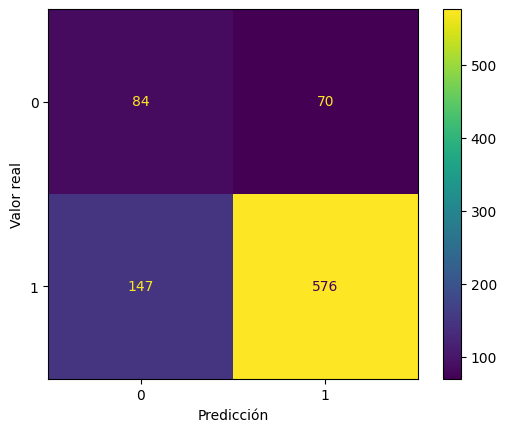

In [519]:
# Plot matriz de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(df_val_opiniones['Label'], df_val_opiniones['Clasificación'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.show()



In [520]:
from sklearn.metrics import classification_report

print(classification_report(df_val_opiniones['Label'], df_val_opiniones['Clasificación']))

              precision    recall  f1-score   support

           0       0.36      0.55      0.44       154
           1       0.89      0.80      0.84       723

    accuracy                           0.75       877
   macro avg       0.63      0.67      0.64       877
weighted avg       0.80      0.75      0.77       877



In [521]:
df_val_opiniones['Clasificación'].value_counts()

Clasificación
1    646
0    231
Name: count, dtype: int64

In [522]:
# Verdaderos positivos y Verdaderos negativos
df_val_opiniones['Label'].value_counts()

Label
1    723
0    154
Name: count, dtype: int64

In [523]:
# Mostrar todo el texto de las columnas
pd.set_option('display.max_colwidth', None)

In [524]:
# Falsos positivos
df_val_opiniones[(df_val_opiniones['Label'] == 0) & (df_val_opiniones['Clasificación'] == 1)][['Title', 'Opinion', 'Place', 'Label','Score', 'Clasificación']]

,Title,Opinion,Place,Label,Score,Clasificación
27,es más viejo que las momias,"en condiciones mediocres, demasiado personal para lo que es, igual el precio, solo vengan si no conocen las momias y por lo iconico que son para la ciudad pero necesitan una renovación urgenteeeeeeeeeeee.",Museo de las Momias,0,0,1
35,¡historia!,"escultura importante que se encuentra sobre una de las colinas, se dice que el pípila vigila hoy la cuidad. un lugar con historia.",Monumento Pípila,0,0,1
569,realismo mágico,"hay una leyenda acerca de este lugar que me parece la de\nromeo y julieta de guanajuato, no la cuento completapara \nque quieran llegar, a mi me parecio muy romantica y este\nlugar debe ser un sitio obligatorio para todas las parejas que\nvisiten guanajuato, así atraeran sus siete años de buena\nsuerte",Callejón del Beso,0,13,1
92,para saber de la infancia del afamado muralista,"se trata de la casa paterna de diego rivera, adaptada como museo. da una idea de la vida de diego en la infancia. en realidad hay más elementos de arte de otros artistas que del mismo diego.",Casa de Diego Rivera,0,18,1
522,bello,"no sé, si sea porque esperaba demasiado, no quiero demeritarlo, es sin duda alguna... algo digno de conocer, es bello, sin embargo yo esperaba algo extraordinario y no lo fue, sin embargo he de recalcar que me tocó una función de teatro gratis y de donde soy ni de broma harían eso.",Teatro Juárez,0,4,1
...,...,...,...,...,...,...
486,museo chafón,"el lugar esta siempre lleno de gente, no tiene nada de labor museográfica, da tristeza ver las malas condiciones generales de ese lugar, explota el morbo de la gente y no tiene atractivo.",Museo de las Momias,0,3,1
408,momificado,"para mí gusto no vale la pena... tristemente es un gran atractivo pero descuidado, complicado para llegar y caótico... las momias empolvadas y mal tenidas según mi impresión. no recomiendo gastar el tiempo allí habiendo cosas más llamativas. a menos que la administración del lugar mejoren las condiciones.",Museo de las Momias,0,3,1
603,"nada extraordinario (tal vez la historia-leyenda), pero sin duda hay que conocerlo","no hay forma de recorrer las calles de guanajuato y no llegar al callejón del beso. la historia es buena, pero el lugar no es algo extraordinario. en un día concurrido, tomarse una fotografía resulta casi en un 'beso grupal'…",Callejón del Beso,0,0,1
457,paciencia. parada\nobligada,"el callejón es una parada obligada en ""guanajuato"". necesitas\npaciencia, pues hay fila para tomarse la foto.\nsi quieres foto en el balcón, cobran $30 pesos por persona \npues los balcones son privados. si la foto sólo es en los \nescalones, no hay que pagar.",Callejón del Beso,0,3,1


In [525]:
# Falsos negativos
df_val_opiniones[(df_val_opiniones['Label'] == 1) & (df_val_opiniones['Clasificación'] == 0)][['Title', 'Opinion', 'Place', 'Label','Score', 'Clasificación']]

,Title,Opinion,Place,Label,Score,Clasificación
3707,es un ícono mexicano,"a pesar de haber mucha gente, la compra de boletos y la entrada al museo fueron ágiles. se empieza el recorrido con un video que explica cómo surgieron las momias, posteriormente puedes decidir si haces el recorrido por tu cuenta o contratas un guía. es interesante ver las momias y conocer algo de la historia de esta ciudad tan emblemática.",Museo de las Momias,1,-85,0
3474,muy interesante,encontraras obras inéditas y podrás observar detalles del monumental mural que pinto en 1947. solicita la visita guiada para apreciar otros detalles interesantes.,Casa de Diego Rivera,1,-6,0
1077,antiguo granero de la ciudad,"alguno no creería que este edificio con aspecto de fortaleza fue originalmente un granero para la ciudad; aunque un granero un tanto lujoso, con un patio espléndido que nada tiene que envidiar a los mejores palacios neoclásicos de méxico d. f. si, además del arte, te interesa la historia, este lugar es imprescindible. aquí se vivió uno de los episodios más importantes de la historia de méxico como nación. visítala y aprenderás mucho más.",Alhóndiga,1,-5,0
836,interesante,"llegar puede ser una experiencia adversa si no lo haces en taxi, mucha subida en un pueblo laberíntico. desde el centro histórico unos 50 pesos mexicanos, barato. la entrada al museo unos 150 pesos mx para descubrir el fenómeno de conservación de los cuerpos conservados a partir de la falta de humedad de los nichos en los que se depositaban para el descanso eterno. esta muy interesante ver el video inicial una vez que entras y luego dejarte guiar por los guías que en 20 minutos aproximandamente te dan la idea total de ese museo. corresponde visitarlo y no se asusten.",Museo de las Momias,1,-107,0
2165,bello edificio,lo malo es que no pudimos entrar al edificio. tal vez por que eran días festivos.,Universidad de Guanajuato,1,-31,0
...,...,...,...,...,...,...
2312,buen lugar,¡excelentes vistas de la ciudad! merece la pena subir en el funicular y disfrutar de las alturas. mejor en la tardecita y ver el cambio de colores a luces de focos ;),Monumento Pípila,1,-4,0
1370,lugar obligado para visitar,definitivamente es un lugar emblemático y romántico para conocer la leyenda y por supuesto para ir a tomarse una foto con la pareja y en el tercer escalón darse un beso para continuar con la tradición bella de guanajuato.,Callejón del Beso,1,-12,0
946,bonito y divertido recorrido con las callejoneadas,visitamos este lugar en el recorrido de una callejoneada con las serenatas de la estudiantina. tuvimos la suerte de que nos tocó poca gente y esto hizo el recorrido agradable y divertido. es una manera de conocer los rinconcitos interesantes que tiene guanajuato.,Callejón del Beso,1,-12,0
910,experiencia de ultratumba,"una experiencia sobrecogedora el ver los cuerpos momificados desde personas de la tercera edad hasta la momia mas pequeña del mundo, un feto de 6 meses de edad, así como fotografías del siglo pasado con familias retratadas con sus hijos muertos.",Museo de las Momias,1,-4,0
